# Sentiment Analysis: Spotify Review App

Regarding the data, the dataset was taken from Kaggle. This is a dataset for __binary sentiment classification__.

Basically a basic sentiment analysis problem, as in this case, consists of a classification problem, where the possible output labels are: `positive` and `negative`. Which indicates, if the review of a Spotify App speaks positively or negatively. In our case it is a binary problem, but one could have many more "feelings" tagged and thus allow a more granular analysis.

### These are the objectives of the project:

* Put together a set of preprocessing functions that we can use later on any NLP or related problems.
* Vectorize the data in order to apply a machine learning model to it: using BoW, TF-IDF or Word2Vec.
* Train a sentiment analysis model that allows us to detect positive, negative and neutral opinions in movie reviews.

---
## 1. Get the data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display
import warnings
import time
import math
import joblib
from scipy import sparse
%matplotlib inline

In [9]:
data = pd.read_csv("/Users/carolinapeinado/Desktop/Santi/SpotifyAppReviews/files/reviews.csv")

In [10]:
data

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN
...,...,...,...,...,...
61589,2022-01-01 03:01:29,Even though it was communicated that lyrics fe...,1,6,NaN
61590,2022-01-01 02:13:40,"Use to be sooo good back when I had it, and wh...",1,0,NaN
61591,2022-01-01 01:02:29,This app would be good if not for it taking ov...,2,10,NaN
61592,2022-01-01 00:49:23,The app is good hard to navigate and won't jus...,2,1,NaN


---
## 2. Data Analysis and Pre-Procesing

In [11]:
print("BASIC INFO")
print('-'*20,"\n")
print("The shape of the dataset is:",data.shape,"\n")
columns = list(data.columns)

data_0 = data.copy()
print("Percentage of missing values")
data_0 = data_0.dropna().reset_index(drop=True)
empties = data_0.isna().sum()
empties_sort = empties.sort_values(ascending= False) 
empties_sort_per = (empties_sort/len(data_0))
print(empties_sort_per,"\n")

print("The columns of the dataset are:",columns,"\n")
for i in range(len(columns)):
  print(f"The type of {columns[i]} column is:", data[str(columns[i])].dtypes)

BASIC INFO
-------------------- 

The shape of the dataset is: (61594, 5) 

Percentage of missing values
Time_submitted    0.0
Review            0.0
Rating            0.0
Total_thumbsup    0.0
Reply             0.0
dtype: float64 

The columns of the dataset are: ['Time_submitted', 'Review', 'Rating', 'Total_thumbsup', 'Reply'] 

The type of Time_submitted column is: object
The type of Review column is: object
The type of Rating column is: int64
The type of Total_thumbsup column is: int64
The type of Reply column is: object


In [12]:
#Let´s analyze the amount of duplicates on the "Review" column..
data.drop_duplicates(subset=["Review"], keep="first", inplace=True)
data["Review"].describe()

count                                                 61356
unique                                                61356
top       Great music service, the audio is high quality...
freq                                                      1
Name: Review, dtype: object

We have 61356 Reviews, each one of them different. It seems, that the Time when the Review was made and wheter if was a Reply from Spoty ot not, it won´t give me much of useful information for further Analysis, hence I am going to eliminate both columns to continue with the EDA.

In [13]:
del data["Reply"]
del data["Time_submitted"]
data

,Review,Rating,Total_thumbsup
0,"Great music service, the audio is high quality...",5,2
1,Please ignore previous negative rating. This a...,5,1
2,"This pop-up ""Get the best Spotify experience o...",4,0
3,Really buggy and terrible to use as of recently,1,1
4,Dear Spotify why do I get songs that I didn't ...,1,1
...,...,...,...
61589,Even though it was communicated that lyrics fe...,1,6
61590,"Use to be sooo good back when I had it, and wh...",1,0
61591,This app would be good if not for it taking ov...,2,10
61592,The app is good hard to navigate and won't jus...,2,1


Basic Info of the Rating feedback...
5    21941
1    17610
4     7821
2     7108
3     6876
Name: Rating, dtype: int64 



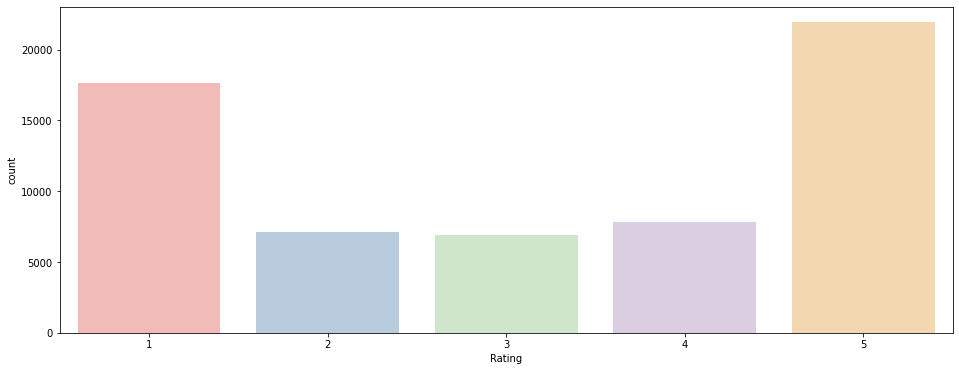

The percentage of the value 1 is of 28.7 % 

The percentage of the value 2 is of 11.58 % 

The percentage of the value 3 is of 11.21 % 

The percentage of the value 4 is of 12.75 % 

The percentage of the value 5 is of 35.76 % 



In [14]:
print("Basic Info of the Rating feedback...")
a = data["Rating"].value_counts()
print(a,"\n")
plt.figure(figsize=(16,6))
sns.countplot(data=data, x="Rating", palette='Pastel1')
plt.show()

total = data.shape[0]
for i in range(6):
  if i != 0:
    percentage = a[i]/total
    print(f"The percentage of the value {i} is of",round(percentage,4)*100,"%","\n")


Another relevant Feature is the validation for each review, each comment has been "evaluated" by other users. I only have the thumbsUp of each review, which is good enough for us to know the "Reliability" or "Strength" of each comment.

In [15]:
#Basic Info of the ThumbsUp feedback.
a = data.copy()
a = a.sort_values("Total_thumbsup", ascending=False)
a

,Review,Rating,Total_thumbsup
36968,The app is very good. I got to explore many ne...,4,8195
37523,Forever glitchy. App play button and current s...,1,6026
4877,there was a drop down thing that I think has r...,4,5336
31673,2 years of use so far. This is my favorite app...,4,4791
35203,Fantastic app. Have always had a great experie...,5,4777
...,...,...,...
22107,Works well but a light mode should be introduced,4,0
22108,"It's an overall great app, there isn't much to...",5,0
22109,"Sucks, needs to restart the app so that app wo...",1,0
22113,"Please fix the apps, can't have premium subscr...",1,0


I am going to create 3 differents columns which are goiing to indicate the "trustfullness" of each particular review. Starting from "Not_validated", moving on with "Validated" and finishing with "Highly_Validated".

In [16]:
validation_strength = pd.DataFrame(columns=["validation_strength"])
for index, column in data.iterrows():
  if data.loc[index, "Total_thumbsup"] == 0:
    validation_strength.loc[index, "validation_strength"] = "Not_validated"
  elif data.loc[index, "Total_thumbsup"] < 15:
    validation_strength.loc[index, "validation_strength"] = "Validated"
  else:
    validation_strength.loc[index, "validation_strength"] = "Highly_validated"
data = pd.concat([data, validation_strength], axis=1)

#ThumsUp Column elimination
del data["Total_thumbsup"]

In [17]:
data.head(10)

,Review,Rating,validation_strength
0,"Great music service, the audio is high quality...",5,Validated
1,Please ignore previous negative rating. This a...,5,Validated
2,"This pop-up ""Get the best Spotify experience o...",4,Not_validated
3,Really buggy and terrible to use as of recently,1,Validated
4,Dear Spotify why do I get songs that I didn't ...,1,Validated
5,The player controls sometimes disappear for no...,3,Validated
6,I love the selection and the lyrics are provid...,5,Not_validated
7,Still extremely slow when changing storage to ...,3,Highly_validated
8,It's a great app and the best mp3 music app I ...,5,Not_validated
9,"I'm deleting this app, for the following reaso...",1,Highly_validated


I´am going to "tranform" this problem into a simpler problem, which was the objective of it once started... In order to do this, the "Rating" column should be tranform. 
The reviews with 4 or 5 stars will be considered as positive, the ones with 1 or 2 as negative and the ones with 3 as neutral. 

In [19]:
for index, column in data.iterrows():
  if data.loc[index, "Rating"] == 1 or data.loc[index, "Rating"] == 2:
    data.loc[index, "Rating"] = "Negative"
  elif data.loc[index, "Rating"] == 3:
    data.loc[index, "Rating"] = "Neutral"
  else:
    data.loc[index, "Rating"] = "Positive"

data

,Review,Rating,validation_strength
0,"Great music service, the audio is high quality...",Positive,Validated
1,Please ignore previous negative rating. This a...,Positive,Validated
2,"This pop-up ""Get the best Spotify experience o...",Positive,Not_validated
3,Really buggy and terrible to use as of recently,Negative,Validated
4,Dear Spotify why do I get songs that I didn't ...,Negative,Validated
...,...,...,...
61589,Even though it was communicated that lyrics fe...,Negative,Validated
61590,"Use to be sooo good back when I had it, and wh...",Negative,Not_validated
61591,This app would be good if not for it taking ov...,Negative,Validated
61592,The app is good hard to navigate and won't jus...,Negative,Validated


# OneHotEncoding the Non-Numeric Variables

In [21]:
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings. simplefilter("ignore")

In [20]:
#OneHotEnconding
def encoding(df, col_list):
  encoder = OneHotEncoder().fit(df[col_list])
  df = pd.concat(
      [
          df,
          pd.DataFrame(
              encoder.transform(df[col_list]).toarray(),
              index=df.index,
              columns=encoder.get_feature_names(col_list)
          )
      ],
      axis=1
  )

  df.drop(["validation_strength"], axis=1, inplace=True)

  return df

In [22]:
#Function Call
col_list = ["validation_strength"]
data = encoding(data, col_list)

#Transforming new columns into integers
data = data.astype({"validation_strength_Highly_validated": int, "validation_strength_Not_validated": int, "validation_strength_Validated":int})

data

,Review,Rating,validation_strength_Highly_validated,validation_strength_Not_validated,validation_strength_Validated
0,"Great music service, the audio is high quality...",Positive,0,0,1
1,Please ignore previous negative rating. This a...,Positive,0,0,1
2,"This pop-up ""Get the best Spotify experience o...",Positive,0,1,0
3,Really buggy and terrible to use as of recently,Negative,0,0,1
4,Dear Spotify why do I get songs that I didn't ...,Negative,0,0,1
...,...,...,...,...,...
61589,Even though it was communicated that lyrics fe...,Negative,0,0,1
61590,"Use to be sooo good back when I had it, and wh...",Negative,0,1,0
61591,This app would be good if not for it taking ov...,Negative,0,0,1
61592,The app is good hard to navigate and won't jus...,Negative,0,0,1


In [23]:
data.to_csv("df_post_ohe.csv")

# Let´s "clean" the text from the Review column...

In [24]:
import text_normalizer

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [25]:
for index,column in data.iterrows():
  data.loc[index,"Review"] = text_normalizer.clean_text(
    text=data.loc[index,"Review"],
    puncts=True,
    stopwords=True,
    urls=True,
    emails=True,
    numbers=True,
    emojis=True,
    special_char=True,
    phone_num=True,
    non_ascii=True,
    multiple_whitespaces=True,
    contractions=True,
    currency_symbols=True,
    custom_pattern=None,
  )
  data.loc[index,"Review"] = text_normalizer.lemmatize_text(data.loc[index,"Review"])

In [26]:
data

,Review,Rating,validation_strength_Highly_validated,validation_strength_Not_validated,validation_strength_Validated
0,great music service audio high quality app eas...,Positive,0,0,1
1,ignore previous negative rating app super grea...,Positive,0,0,1
2,popup well spotify experience android annoying...,Positive,0,1,0
3,buggy terrible use recently,Negative,0,0,1
4,dear spotify song do not playlist shuffle play,Negative,0,0,1
...,...,...,...,...,...
61589,communicate lyric feature available user globa...,Negative,0,0,1
61590,use sooo good download free version could not ...,Negative,0,1,0
61591,app good take device start comp there s spotif...,Negative,0,0,1
61592,app good hard navigate will not let play song ...,Negative,0,0,1


In [27]:
data.to_csv("df_cleaned.csv")

In [2]:
data = pd.read_csv("/Users/carolinapeinado/Desktop/Santi/SpotifyAppReviews/files/df_cleaned.csv", index_col=0)

# Quick Analysis of the text/words on the column "Review"

In [29]:
from wordcloud import WordCloud

In [50]:
# Generating the respective texts for each particular sentiment analysis
positive_text = []
negative_text = []
neutral_text  = []
for index, columns in data.iterrows():
    if data.loc[index,"Rating"] == "Positive":
        positive_text.append(data.loc[index,"Review"])
    elif data.loc[index,"Rating"] == "Neutral":
        neutral_text.append(data.loc[index,"Review"])
    else:
        negative_text.append(data.loc[index,"Review"])

positive_text = str(positive_text)
negative_text = str(negative_text)
neutral_text  = str(neutral_text)

POSOTIVE REVIEWS


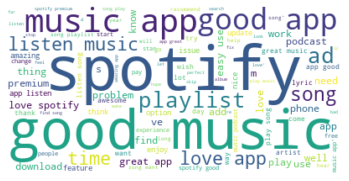

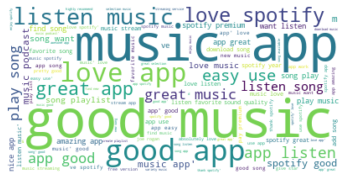

NEGATIVE REVIEWS


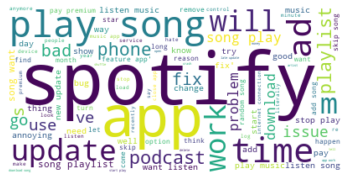

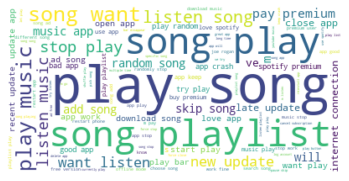

NEUTRAL REVIEWS


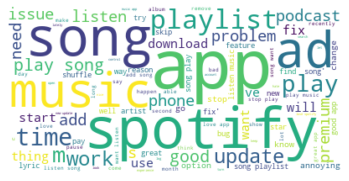

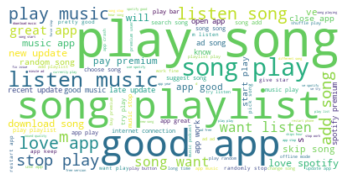

In [55]:
def show_wordcloud(text, sent):
    print(sent)
    #WordClod of just 1 word
    wordcloud = WordCloud( max_words=100, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    #WordCloud of two words
    wordcloud_2 = WordCloud(collocation_threshold = 2, collocations= True, max_words=100, background_color="white").generate(text)
    plt.imshow(wordcloud_2, interpolation='bilinear')
    plt.axis("off")
    plt.show()

sents = ["POSOTIVE REVIEWS", "NEGATIVE REVIEWS", "NEUTRAL REVIEWS"]
texts = [positive_text, negative_text, neutral_text]
for i in range(len(texts)):
    show_wordcloud(texts[i], sents[i])

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
X = data.drop(["Rating"],axis=1)
y = data["Rating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, shuffle=True,stratify=y)

In [59]:
#Quick chek over the shapes of the divided Data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(42949, 4)
(18407, 4)
(42949,)
(18407,)


---
## 3. Feature Engineering

For this step we have a variaty of options to choose. It is known by now that the best, in general terms, is using some of the Word Embedding already created from the big corporations such as Word2Vec(Google) or GloVe(Stanford). Also, I could make my own Embedding with the Gensim Library. There are several options, one more "expensive" (computationally speaking) than the other but also more effective. A good practive would be trying some of them and make a comparison...

In [ ]:
#BoW

#Tf-Idf

#My own Word Embedding

#Using Word2vec


With this step we finish with the first part of the Pipeline for this NLP project. We will be holding the Model Evaluations and selection on its respective Notebook, "ModelEvaluation".